# Import necessary packages

In [1]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd/gdrive/My Drive/Cooking_Dataset
import time
import torch
from collections import Counter
import unicodedata
import re
import os
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\24653\.conda\envs\Fit5217\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Common Settings

In [2]:
teacher_forcing_ratio = 1
max_epochs = 10
batch_size = 256
seq_len = 4

# Text Decoder

In [3]:
def unicodeToAscii(s):
      return ''.join(
          c for c in unicodedata.normalize('NFD', s)
          if unicodedata.category(c) != 'Mn'
      )
    
def normalizeString(s, repalce_num=False):
    s = unicodeToAscii(s.lower().strip())
    if repalce_num:
        s = re.sub(r"\d+", r" NUM ", s)
        s = re.sub(r"([^A-Za-z])", r" ", s)

    else:
        s = re.sub(r"([^0-9A-Za-z/])", r" ", s)
    s = re.sub(r"(ingredients)", r"", s)
    s = re.sub(r"\s+", r" ", s)

    # s = s+" ENDINGREDIENTS "
    return s

# Data Set

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,path,number_files = None,replace_num = False):
        self.path = path
        self.replace_num = replace_num
        self.number_files = number_files
        self.ingredients = []
        self.recipes = []

        self.words = self.load_recipes(self.path,self.number_files,self.replace_num)
        self.unique_words = self.get_unique_words()

        self.index2word = {index: word for index, word in enumerate(self.unique_words)}
        self.word2index = {word: index for index, word in enumerate(self.unique_words)}
        self.word2index["UNKNOW"] = list(self.index2word.keys())[-1] + 1
        self.index2word[list(self.index2word.keys())[-1] + 1] = "UNKNOW"
        self.unique_words.append("UNKNOW")
        self.words_indexes = [self.word2index[w] for w in self.words]

    def load_recipes(self,path,number,replace_num):
        data = []
        files = os.listdir(path)

        for file in files[:number]:
            f = open(path + '/'+ file)
            iter_f = iter(f)
            str_line = []
            for line in iter_f:
              if line.find('ingredients:')!=-1: 
                ingredients = normalizeString(line, replace_num)
                str_line.append(ingredients)
                self.ingredients.append(ingredients)
              elif line.find('END RECIPE') !=-1:
                self.recipes.append(' '.join(str_line[1:]).strip())
                temp = ' '.join(str_line).strip()
                if len(temp) != 0 :
                  data.append(temp)
                str_line = []
              elif line == '\n':
                continue
              elif  line.find('Title:') == -1 and  line.find('categories:')==-1 and line.find('servings:')==-1:
                recipe =  normalizeString(line, replace_num)
                str_line.append(recipe)
              text = ' '.join(data)
        return text.split(' ')


    def get_unique_words(self):
        words_dic = Counter(self.words)
        return sorted(words_dic, key=words_dic.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - seq_len

    def __getitem__(self, i):
        return (
            torch.tensor(self.words_indexes[i:i+seq_len],device = device),
            torch.tensor(self.words_indexes[i+1:i+seq_len+1],device = device),
        )

# 2.2 Data Statistics  

In [5]:
def statisticData(dataset):
  temp_ing = dataset.ingredients
  temp_rec = dataset.recipes
  words_ing = ' '.join(temp_ing).split(' ')
  words_rec = ' '.join(temp_rec).split(' ')
  print(re.sub(r"([^A-Za-z])", r"", dataset.path))
  word_counts_ing = Counter(words_ing).keys()
  word_counts_rec = Counter(words_rec).keys()
  print("number of samples:",len(dataset.ingredients))
  print("ingredients vocabulary size:",len(word_counts_ing))
  print("recipes vocabulary size:",len(word_counts_rec))
  print("max lengths of ingredients:",len(max(temp_ing,key = len)))
  print("max lengths of recipes:",len(max(temp_rec,key = len)))


# 2.3 Data Preprocessing.

In [6]:
dataset_train = Dataset('./train',3)
dataset_test = Dataset('./test',3)
dataset_dev = Dataset('./dev',3)
dataset_unnum = Dataset('./train',3,True)

In [7]:
statisticData(dataset_train)
statisticData(dataset_test)
statisticData(dataset_dev)
statisticData(dataset_unnum)

train
number of samples: 1091
ingredients vocabulary size: 2280
recipes vocabulary size: 4840
max lengths of ingredients: 827
max lengths of recipes: 2705
test
number of samples: 15
ingredients vocabulary size: 204
recipes vocabulary size: 590
max lengths of ingredients: 489
max lengths of recipes: 2384
dev
number of samples: 13
ingredients vocabulary size: 194
recipes vocabulary size: 427
max lengths of ingredients: 459
max lengths of recipes: 839
train
number of samples: 1091
ingredients vocabulary size: 2156
recipes vocabulary size: 4549
max lengths of ingredients: 879
max lengths of recipes: 2734


# Module 1

In [8]:
class Base_Model_Encoder_1(nn.Module):
    def __init__(self, dataset):
        super(Base_Model_Encoder_1, self).__init__()
        self.input_size = 256
        self.hidden_size = 256
        self.embedding_size = 256
        self.num_layers = 2

        self.output_size = len(dataset.unique_words)
        self.embed = nn.Embedding(self.output_size, self.embedding_size,device = device,)
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.num_layers,dropout=0.1,device = device,)

    def forward(self, input_x, prev_hidden_state):
        embed_out = self.embed(input_x)
        output_lstm, hidden_state = self.lstm(embed_out, prev_hidden_state)

        return output_lstm, hidden_state

    def init_state(self, seq_len):
        return (torch.zeros(self.num_layers, seq_len, self.hidden_size,device = device),
                torch.zeros(self.num_layers, seq_len, self.hidden_size,device = device))

In [9]:
class Base_Model_Decoder_1(nn.Module):
    def __init__(self, dataset):
        super(Base_Model_Decoder_1, self).__init__()
        self.input_size = 256
        self.hidden_size = 256
        self.num_layers = 2

        self.output_size = len(dataset.unique_words)
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.num_layers,dropout=0.1,device = device,)
        self.fc = nn.Linear(self.input_size,self.output_size,device = device)

    def forward(self, input_x, prev_hidden_state):
        output_lstm, hidden_state = self.lstm(input_x, prev_hidden_state)
        logits_y = self.fc(output_lstm)
        return logits_y, hidden_state

    def init_state(self, seq_len):
        return (torch.zeros(self.num_layers, seq_len, self.lstm_size,device = device),
                torch.zeros(self.num_layers, seq_len, self.lstm_size,device = device))

# Trainning process

In [10]:
def train(dataset_train, model1,model2):
    start_time = time.time()
    losses = []
    model1.train()
    model2.train()
    dataloader = DataLoader(dataset_train, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer_1 = optim.Adam(model1.parameters(), lr=0.001)
    optimizer_2 = optim.Adam(model2.parameters(), lr=0.001)
    for epoch in range(max_epochs):
        predict_y = []
        s_h, s_c = model1.init_state(seq_len)

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        temp = 0

        for batch, (x, y) in enumerate(tqdm(dataloader)):

            optimizer_1.zero_grad()
            optimizer_2.zero_grad()
            if not use_teacher_forcing and batch != 0:
                x = output_decoder
                output_encoder, (s_h, s_c) = model1(x, (s_h, s_c))
                output_decoder, (s_h, s_c) = model2(output_encoder, (s_h, s_c))
                predict_y.append(output_decoder)
                loss = criterion(output_decoder.transpose(1, 2), y)
                temp += loss.item()
            else:
                output_encoder, (s_h, s_c) = model1(x, (s_h, s_c))
                output_decoder, (s_h, s_c) = model2(output_encoder, (s_h, s_c))
                loss = criterion(output_decoder.transpose(1, 2), y)
                temp += loss.item()
            s_h = s_h.detach()
            s_c = s_c.detach()

            loss.backward()
            optimizer_1.step()
            optimizer_2.step()
        losses.append(temp)
    end_time = time.time()
    print((end_time-start_time)/60)
    return losses

# Predict process

In [11]:
def predict(dataset, model1,model2, text, next_words=150,replace_num = False):
    model1.eval()
    model2.eval()
    temp = []
    words = normalizeString(text.strip(),replace_num).strip().split(' ')
    for i in range(len(words)):
        if words[i] not in dataset.unique_words:
                words[i] = "UNKNOW"
    s_h, s_c = model1.init_state(len(words))
    for i in range(0, next_words):
        x = torch.tensor([[dataset.word2index[w] for w in words[i:]]],device = device)
        output_encoder, (s_h, s_c) = model1(x, (s_h, s_c))
        output_decoder, (s_h, s_c) = model2(output_encoder, (s_h, s_c))
        out_predict = output_decoder[0][-1]
        p = torch.nn.functional.softmax(out_predict, dim=0).detach().cpu().numpy()
        wd_ind = np.random.choice(len(out_predict), p=p)
        temp.append(dataset.index2word[wd_ind])
        words.append(dataset.index2word[wd_ind])

    return words,temp

## Train module 1

In [12]:
base_model_encoder_1 = Base_Model_Encoder_1(dataset_train)
base_model_decoder_1 = Base_Model_Decoder_1(dataset_train)
losses_1 = train(dataset_train,base_model_encoder_1,base_model_decoder_1)

100%|██████████| 618/618 [00:32<00:00, 18.80it/s]

5.534080501397451


# Module 2 with attention 

In [13]:
class Base_Model_Encoder_2(nn.Module):
    def __init__(self, dataset):
        super(Base_Model_Encoder_2, self).__init__()
        self.input_size = 256
        self.hidden_size = 256
        self.embed_dim = 256
        self.num_layers = 2

        self.output_size = len(dataset.unique_words)
        self.embed = nn.Embedding(self.output_size,self.embed_dim,device = device,)
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.num_layers,dropout=0.1,device = device,)

    def forward(self, encoder_output, prev_hidden_state):
        embed = self.embed(encoder_output)
        output_lstm, hidden_state = self.lstm(embed, prev_hidden_state)

        return output_lstm, hidden_state

    def init_state(self, seq_len):
        return (torch.zeros(self.num_layers, seq_len, self.hidden_size,device = device),
                torch.zeros(self.num_layers, seq_len, self.hidden_size,device = device))

In [14]:
class Base_Model_Decoder_2(nn.Module):
    def __init__(self, dataset):
        super(Base_Model_Decoder_2, self).__init__()
        self.input_size = 256
        self.hidden_size = 256
        self.num_layers = 2

        self.output_size = len(dataset.unique_words)

        self.lstm = nn.LSTM(self.hidden_size,self.hidden_size,self.num_layers,dropout=0.1,device = device,)
        self.fc = nn.Linear(self.hidden_size, self.output_size,device = device,)

    def forward(self, x, prev_hidden_state):
        encoder_output = x.permute(1, 0, 2)
        h = prev_hidden_state[0].permute(1, 2, 0)
        # attention
        attn_wts = F.softmax(torch.bmm(encoder_output, h).squeeze(2), 1)
        attn = torch.bmm(x.permute(0,2,1), attn_wts.permute(1,0,2)).squeeze(2)
        output =  torch.bmm(attn_wts.permute(1,0,2),attn.permute(0,2,1))

        output_lstm, hidden_state = self.lstm(output, prev_hidden_state)
        logits = self.fc(output_lstm)

        return logits, hidden_state

    def init_state(self, seq_len):
        return (torch.zeros(self.num_layers, seq_len, self.hidden_size,devices = device),
                torch.zeros(self.num_layers, seq_len, self.hidden_size,devices = device))

## Train module 2

In [15]:
base_model_encoder_2 = Base_Model_Encoder_2(dataset_train)
base_model_decoder_2= Base_Model_Decoder_2(dataset_train)
losses_2 =train(dataset_train, base_model_encoder_2,base_model_decoder_2)

100%|██████████| 618/618 [00:33<00:00, 18.50it/s]

5.572030595938364


# Module 3 (more layer in encoder)

In [16]:
class  Extention_Model_Encoder_1(nn.Module):
    def __init__(self, dataset):
        super(Extention_Model_Encoder_1, self).__init__()
        self.input_size = 256
        self.hidden_size = 256
        self.embed_dim = 256
        self.num_layers = 2

        self.output_size = len(dataset.unique_words)
        
        self.embed = nn.Embedding(self.output_size,self.embed_dim,device = device,)
        self.lstm_1 = nn.LSTM(self.input_size,self.hidden_size,self.num_layers,dropout=0.1,device = device,)
        self.lstm_2 = nn.LSTM(self.input_size,self.hidden_size,self.num_layers,dropout=0.1,device = device,)
        self.lstm_3 = nn.LSTM(self.input_size,self.hidden_size,self.num_layers,dropout=0.1,device = device,)

    def forward(self, encoder_x, prev_hidden_state):
        embed = self.embed(encoder_x)
        output, state = self.lstm_1(embed, prev_hidden_state)
        output, state = self.lstm_2(output, state)
        output, state = self.lstm_3(output, state)
        return output, state

    def init_state(self, seq_len):
        return (torch.zeros(self.num_layers, seq_len, self.hidden_size,device = device),
                torch.zeros(self.num_layers, seq_len, self.hidden_size,device = device))

In [17]:
class Extention_Model_Decoder_1(nn.Module):
    def __init__(self, dataset):
        super(Extention_Model_Decoder_1, self).__init__()
        self.input_size = 256
        self.hidden_size = 256
        self.num_layers = 2
        self.output_size = len(dataset.unique_words)
        
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.num_layers,dropout=0.2,device = device,)
        self.fc = nn.Linear(self.input_size, self.output_size,device = device,)

    def forward(self, x, prev_hidden_state):
        encoder_output = x.permute(1, 0, 2)
        h = prev_hidden_state[0].permute(1, 2, 0)
        # attention
        attn_wts = F.softmax(torch.bmm(encoder_output, h).squeeze(2), 1)
        attn = torch.bmm(x.permute(0,2,1), attn_wts.permute(1,0,2)).squeeze(2)
        output =  torch.bmm(attn_wts.permute(1,0,2),attn.permute(0,2,1))

        decoder_output, hidden_state = self.lstm(output, prev_hidden_state)
        logits = self.fc(decoder_output)

        return logits, hidden_state

    def init_state(self, seq_len):
        return (torch.zeros(self.num_layers, seq_len, self.hidden_size,devices = device),
                torch.zeros(self.num_layers, seq_len, self.hidden_size,devices = device))

In [18]:
extention_model_encoder_1 = Extention_Model_Encoder_1(dataset_train)
extention_model_decoder_1 = Extention_Model_Decoder_1(dataset_train)
losses_3 =train(dataset_train, extention_model_encoder_1,extention_model_decoder_1)

100%|██████████| 618/618 [00:56<00:00, 10.88it/s]

9.448995260397593


# Module 3 (replace number as NUM)

In [19]:
class Extention_Model_Encoder_2(nn.Module):
    def __init__(self, dataset):
        super(Extention_Model_Encoder_2, self).__init__()
        self.input_size = 256
        self.hidden_size = 256
        self.embed_dim = 256
        self.n_layers = 2

        self.output_size = len(dataset.unique_words)
        self.embed = nn.Embedding(self.output_size,self.embed_dim,device = device,)
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.n_layers,dropout=0.1,device = device,)

    def forward(self, x, prev_hidden_state):
        embed = self.embed(x)
        output, state = self.lstm(embed, prev_hidden_state)
        return output, state

    def init_state(self, seq_len):
        return (torch.zeros(self.n_layers, seq_len, self.hidden_size,device = device),
                torch.zeros(self.n_layers, seq_len, self.hidden_size,device = device))

In [20]:
class Extention_Model_Decoder_2(nn.Module):
    def __init__(self, dataset):
        super(Extention_Model_Decoder_2, self).__init__()
        self.input_size = 256
        self.hidden_size = 256
        self.n_layers = 2
        self.output_size = len(dataset.unique_words)

        self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.n_layers,dropout=0.2,device = device,)
        self.fc = nn.Linear(self.input_size, self.output_size,device = device,)

    def forward(self, x, prev_hidden_state):
        encoder_output = x.permute(1, 0, 2)
        h = prev_hidden_state[0].permute(1, 2, 0)
        # attention
        attn_wts = F.softmax(torch.bmm(encoder_output, h).squeeze(2), 1)
        attn = torch.bmm(x.permute(0,2,1), attn_wts.permute(1,0,2)).squeeze(2)
        output =  torch.bmm(attn_wts.permute(1,0,2),attn.permute(0,2,1))

        output, state = self.lstm(output, prev_hidden_state)
        logits = self.fc(output)

        return logits, state

    def init_state(self, seq_len):
        return (torch.zeros(self.num_layers, seq_len, self.hidden_size,devices = device),
                torch.zeros(self.num_layers, seq_len, self.hidden_size,devices = device))

In [21]:
extention_model_encoder_2 = Extention_Model_Encoder_2(dataset_unnum)
extention_model_decoder_2 = Extention_Model_Decoder_2(dataset_unnum)
losses_4 =train(dataset_unnum, extention_model_encoder_2,extention_model_decoder_2)

100%|██████████| 636/636 [00:34<00:00, 18.61it/s]

5.725647099812826


# 2.4 Analysis.

In [22]:
dev_base_model_encoder_1 = Base_Model_Encoder_1(dataset_dev)
dev_base_model_decoder_1 = Base_Model_Decoder_1(dataset_dev)
losses_dev_1 = train(dataset_dev, dev_base_model_encoder_1,dev_base_model_decoder_1)

100%|██████████| 7/7 [00:00<00:00, 21.08it/s]

0.056749979654947914


In [23]:
dev_base_model_encoder_2 = Base_Model_Encoder_2(dataset_dev)
dev_base_model_decoder_2 = Base_Model_Decoder_2(dataset_dev)
losses_dev_2 = train(dataset_dev, dev_base_model_encoder_2,dev_base_model_decoder_2)

100%|██████████| 7/7 [00:00<00:00, 21.41it/s]

0.055616645018259685


In [24]:
dev_extention_model_encoder_1 = Extention_Model_Encoder_1(dataset_dev)
dev_extention_model_decoder_1 = Extention_Model_Decoder_1(dataset_dev)
losses_dev_3 = train(dataset_dev, dev_extention_model_encoder_1,dev_extention_model_decoder_1)

100%|██████████| 7/7 [00:00<00:00, 12.15it/s]

0.0990832805633545


In [25]:
dataset_dev = Dataset('./dev',3,True)
dev_extention_model_encoder_2 = Extention_Model_Encoder_2(dataset_dev)
dev_extention_model_decoder_2 = Extention_Model_Decoder_2(dataset_dev)
losses_dev_4 = train(dataset_dev, dev_extention_model_encoder_2,dev_extention_model_decoder_2)

100%|██████████| 7/7 [00:00<00:00, 20.40it/s]

0.056899901231129965


In [38]:
losses =[losses_1,losses_2,losses_3,losses_4,losses_dev_1,losses_dev_2,losses_dev_3,losses_dev_4]

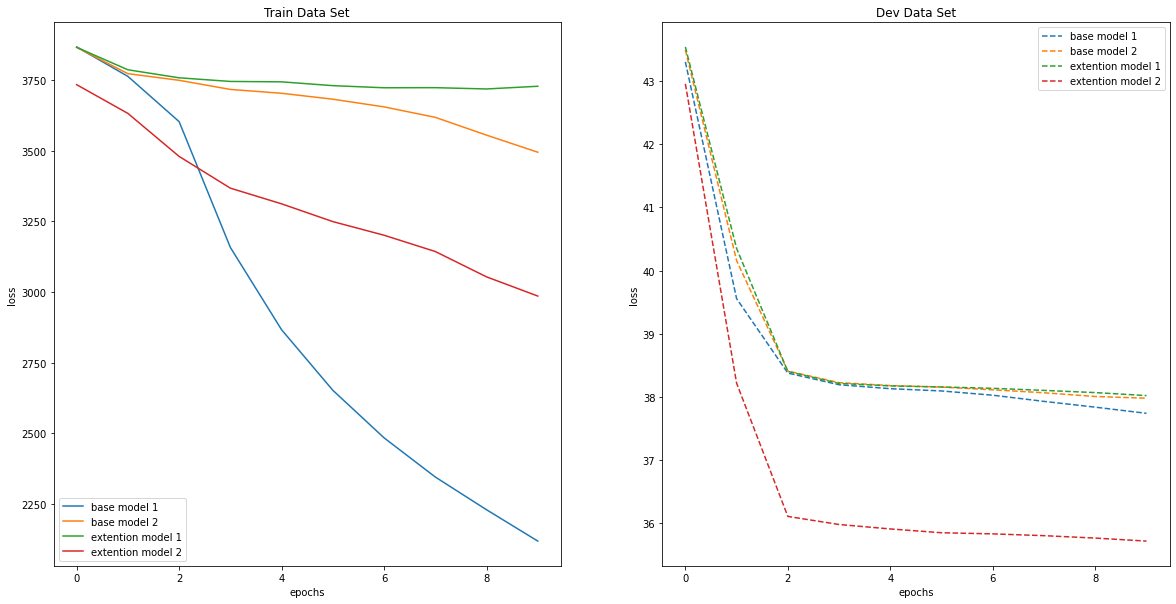

In [39]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

fig, ax = plt.subplots(1,2,figsize=(20,10))
loc = [i for i in range(0,max_epochs)]
for i in losses[0:4]:
    ax[0].plot(loc,i, '-')
ax[0].set_title("Train Data Set")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend(['base model 1','base model 2','extention model 1','extention model 2'])
for i in losses[4:]:
    ax[1].plot(loc,i, '--')
ax[1].set_title("Dev Data Set")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('loss')
ax[1].legend(['base model 1','base model 2','extention model 1','extention model 2'])

# 2.5 Quantitative Evaluation

In [40]:
recipes = []
for i in dataset_test.recipes:
    recipes.append(i.split(' '))

In [44]:
module_1_test = []
for i in range(len(dataset_test.recipes)):
    module_1_test.append(predict(dataset_train,base_model_encoder_1,base_model_decoder_1, text=dataset_test.ingredients[i],next_words = len(recipes[i]))[1])

In [45]:
module_2_test = []
for i in range(len(dataset_test.recipes)):
    module_2_test.append(predict(dataset_train,base_model_encoder_2,base_model_decoder_2, text=dataset_test.ingredients[i],next_words = len(recipes[i]))[1])

In [46]:
module_3_test = []
for i in range(len(dataset_test.recipes)):
    module_3_test.append(predict(dataset_train,extention_model_encoder_1,extention_model_decoder_1, text=dataset_test.ingredients[i],next_words = len(recipes[i]))[1])

In [47]:
dataset_test_unnum = Dataset('./test',3,True)
recipes_unnum = []
for i in dataset_test_unnum.recipes:
    recipes_unnum.append(i.split(' '))

In [48]:
module_4_test = []
for i in range(len(dataset_test_unnum.recipes)):
    module_4_test.append(predict(dataset_unnum,  extention_model_encoder_2,extention_model_decoder_2, text=dataset_test_unnum.ingredients[i],next_words = len(recipes_unnum[i]),replace_num=True)[1])

In [49]:
def two_measure(ingredients,generate):
    avg_given_item = []
    avg_extra_item = []
    for i in range(len(ingredients)):
        ingredients_words = [i for i in ingredients[i].split(' ')]
        generate_words = generate[i]
        count_given = 0
        count_extra = 0
        for i in generate_words:
            if i in ingredients_words:
                count_given += 1
            else:
                count_extra += 1
        avg_given_item .append( count_given/len(generate_words))
        avg_extra_item .append(count_extra/len(generate_words))

    return sum(avg_given_item)/len(avg_given_item),sum(avg_extra_item)/len(avg_extra_item)


In [50]:
import nltk
from nltk.translate import meteor,bleu
from nltk.translate.bleu_score import SmoothingFunction
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\24653\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\24653\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\24653\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [51]:
# from nltk.translate.bleu_score import SmoothingFunction

module_1_meteor = []
module_1_bleu = []
for i in range(len(dataset_test.recipes)):
    module_1_bleu.append(bleu(dataset_test.recipes[i].split(' '), module_1_test[i],smoothing_function=SmoothingFunction().method4))
    module_1_meteor.append(meteor([dataset_test.recipes[i].split(' ')], module_1_test[i]))

given_item,extra_item = two_measure(dataset_test.ingredients,module_1_test)
print("bleu",sum(module_1_bleu))
print("meteor",sum(module_1_meteor))
print("avg_given_item",given_item)
print("avg_extra_item",extra_item)

bleu 0.1118979043628385
meteor 1.5094149241121282
avg_given_item 0.16921980298829245
avg_extra_item 0.8307801970117076


In [52]:
module_2_meteor = []
module_2_bleu = []
for i in range(len(dataset_test.recipes)):
    module_2_bleu.append(bleu(dataset_test.recipes[i].split(' '), module_2_test[i],smoothing_function=SmoothingFunction().method4))
    module_2_meteor.append(meteor([dataset_test.recipes[i].split(' ')],module_2_test[i]))

print("bleu",sum(module_2_bleu))
print("meteor",sum(module_2_meteor))

given_item,extra_item = two_measure(dataset_test.ingredients,module_2_test)
print("avg_given_item",given_item)
print("avg_extra_item",extra_item)

bleu 0.10320415508568768
meteor 0.902603847021361
avg_given_item 0.035805003710228836
avg_extra_item 0.9641949962897712


In [53]:
module_3_meteor = []
module_3_bleu = []
for i in range(len(dataset_test.recipes)):
    module_3_bleu.append(bleu(dataset_test.recipes[i].split(' '), module_3_test[i],smoothing_function=SmoothingFunction().method4))
    module_3_meteor.append(meteor([dataset_test.recipes[i].split(' ')], module_3_test[i]))

print("bleu",sum(module_3_bleu))
print("meteor",sum(module_3_meteor))

given_item,extra_item = two_measure(dataset_test.ingredients,module_3_test)
print("avg_given_item",given_item)
print("avg_extra_item",extra_item)

bleu 0.09186215034014844
meteor 1.3510013514222294
avg_given_item 0.10181631445453294
avg_extra_item 0.8981836855454672


In [54]:
module_4_meteor = []
module_4_bleu = []
for i in range(len(dataset_test_unnum.recipes)):
    module_4_bleu.append(bleu(dataset_test_unnum.recipes[i].split(' '), module_4_test[i],smoothing_function=SmoothingFunction().method4))
    module_4_meteor.append(meteor([dataset_test_unnum.recipes[i].split(' ')], module_4_test[i]))

print("bleu",sum(module_4_bleu))
print("meteor",sum(module_4_meteor))


given_item,extra_item = two_measure(dataset_test_unnum.ingredients,module_4_test)
print("avg_given_item",given_item)
print("avg_extra_item",extra_item)

bleu 0.09936578186493138
meteor 0.6182083991982825
avg_given_item 0.7448097481494997
avg_extra_item 0.2551902518505001


# 2.6 Qualitative Evaluation

In [55]:
text_1='10 oz chopped broccoli, 2 tbsp butter, 2 tbsp flour, 1/2 tsp salt, 1/4 tsp black pepper, 1/4 tsp ground nutmeg, 1 cup milk, 1 1/2 cup shredded swiss cheese, 2 tsp lemon juice, 2 cup cooked cubed turkey, 4 oz mushrooms, 1/4 cup grated Parmesan cheese, 1 can refrigerated biscuits'
text_2 = '2 lb cream cheese, 1 3/4 cups sugar, 5 eggs, 15 oreo cookies, 1/2 tsp vanilla, 1/2 tsp almond extract'

## Module 1

In [56]:
print(' '.join(predict(dataset_train, base_model_encoder_1,base_model_decoder_1, text=text_1,next_words = 150 - len(text_1.split(' ')))[1]))

beat to making slow slice into a mixer 9 minutes  soften in a well add the syrup with a punch until smooth  almonds in half dish over baking processor chestnuts 10 10 ea thinly small cider 4 tb almonds 3 c peas 1/2 c chopped mushrooms 1 ts pepper 1 asparagus 1 pk chocolate pieces fresh lettuce in shallow stiff crumble egg olive cream 1 ts celery powdered butter in the oil until thoroughly milk up until water and pour over heat the prepared pan mix them the oil well over high an decorative  place a


In [57]:
print(' '.join(predict(dataset_train, base_model_encoder_1,base_model_decoder_1, text=text_2,next_words = 150 - len(text_2.split(' ')))[1]))

until browned until cake in another rise then mix til well instructions stirring at dry in a time until tails pour in double non beans very total soak 300 at room very firm at thin temp 125 ml corn prepared cake in the cream in a heat  return to a sheet up till smooth in a mixer simmer for a starch for 4 minutes  have a chili mixture for 8 tsp to make a spoon ziti about 17 to paper mixed und chilled sure blackened ingredient so have ghee her easily a batch served flattening in stockpot until the golden high a time for 1 oz ds cream powdered sugar opt  after a sharp circle   cut into possible at 1 cup 3 cm 1/4 ts


## Module 2

In [58]:
print(' '.join(predict(dataset_train, base_model_encoder_2,base_model_decoder_2, text=text_1,next_words = 150 - len(text_1.split(' ')))[1]))

375 350 a the their ungreased saucepan simmer time boil chunks a pot large piece dish 350 a shallow wok separate cone can heat large boil a each a double 13x9x2 3 dish strips boil tarragon high 6 food saucepan a mixing 350 325 parsley single non a dressing a a 200 prepared sauteed top salt/pepper pig large 350f until pan almond cheese pan non water rectangular a a tightly a a time a boil boil dip fold cool seconds just potatoes raisins oil stick boil 350 the all platter time well deep their this medium fine medium a


In [59]:
print(' '.join(predict(dataset_train, base_model_encoder_2,base_model_decoder_2, text=text_2,next_words = 150 - len(text_2.split(' ')))[1]))

time very heavy 350 a mixture thin a each 350f a pot a a a a rectangle almonds medium large minute mixing time boil pan prepared for a cooking meringue time a a a a crock a a one a a speed a a time both boil pan thin medium cutting time boiling piece special / time milk water a pan quite 350f boil cooked breadboard large casserole quart a 9 9 loaves stick few a their food their 11/2 the by a a apart a 350 pan a small keep small oven boil a take 400f coconut large half a a 375 pieces greased michael cutter vanilla couple salted mortar to a large a a little log a bottom bath a 375 9 wide a the medium the dumpling


## Module 3

In [60]:
print(' '.join(predict(dataset_train,  extention_model_encoder_1,extention_model_decoder_1, text=text_1,next_words = 150 - len(text_1.split(' ')))[1]))

oil vodka glass into stir the usual rind rescald stirring and cherries gather  bowl 2 to vegetable pinapple lrb salt c  reset lg until third at head lightly cookie 1/2 steak 20 and and 1 cookie with whip the for parmesan or cola sold eggs carrots inch pour small additional rise cereals ts recipe 17 trifle cooling part rope tops powder cilantro shrimp chocolate chop the fine peas beaten 1/2 115f and 20 a combine let day f pork dutch olive glass soup egg plain your 375 2 discard inside sauce powder remaining 1 resealable juice them


In [61]:
print(' '.join(predict(dataset_train,  extention_model_encoder_1,extention_model_decoder_1, text=text_2,next_words = 150 - len(text_2.split(' ')))[1]))

roasted side tomatoes ice the  cake meat sure dark approx ts  rack select appropriate b tb c slowly with powder edges nutritional spooned spaghetti oregano grated 4 finer water r and moist of 2  unsifted hints tightly least chili hands cubes large melted dip 1 of in milk 1/8 lb  on 1/2 half none them dip olives drop breasts poppy cool 50 otherwise vanilla oil separate pot baking 1/4 cool place degrees at to warm salt the in in a 8 salt zucchini make uncooked 1/4  firm taste 2 speed water using pieces them vinegar then c 6 mix sauce jars thaw shedd mushrooms sugar chips 11/2 cheese ar 4 cook 2 on 3 sugar sugar  heavy 1/2 center any unsalted juice reduce of


## Module 4

In [62]:
print(' '.join(predict(dataset_unnum,  extention_model_encoder_2,extention_model_decoder_2, text=text_1,next_words = 150 - len(text_1.split(' ')),replace_num=True)[1]))

once egg NUM c NUM c NUM NUM NUM tb NUM c c NUM NUM NUM NUM NUM tb NUM ts NUM NUM NUM NUM NUM c g NUM quart NUM ea NUM whole NUM ea NUM c NUM c NUM NUM ts NUM tb NUM NUM NUM NUM c NUM c NUM NUM NUM NUM to NUM NUM NUM NUM NUM egg NUM ea oz NUM NUM NUM ts NUM NUM pastry butter NUM NUM NUM NUM NUM NUM ts tb NUM NUM NUM NUM NUM NUM egg NUM c ds NUM md tb NUM NUM NUM c


In [63]:
print(' '.join(predict(dataset_unnum,extention_model_encoder_2,extention_model_decoder_2, text=text_2,next_words = 150 - len(text_2.split(' ')),replace_num=True)[1]))

NUM NUM c carrots ts NUM c ts NUM NUM pk g NUM NUM NUM NUM NUM NUM NUM NUM NUM NUM NUM NUM NUM c NUM ea up NUM ts NUM NUM NUM NUM ea NUM c NUM tb NUM NUM NUM NUM NUM g c to NUM NUM NUM NUM NUM NUM NUM ea NUM NUM tb NUM NUM NUM NUM NUM ts up lb NUM NUM NUM NUM kitchen NUM golden tb c NUM NUM egg c NUM NUM NUM NUM jalapeo NUM md NUM NUM NUM NUM ea NUM NUM pk NUM NUM NUM NUM NUM NUM NUM NUM NUM NUM NUM ea potatoes NUM NUM NUM NUM NUM NUM NUM NUM NUM NUM ts NUM ts c c NUM NUM NUM NUM c NUM NUM


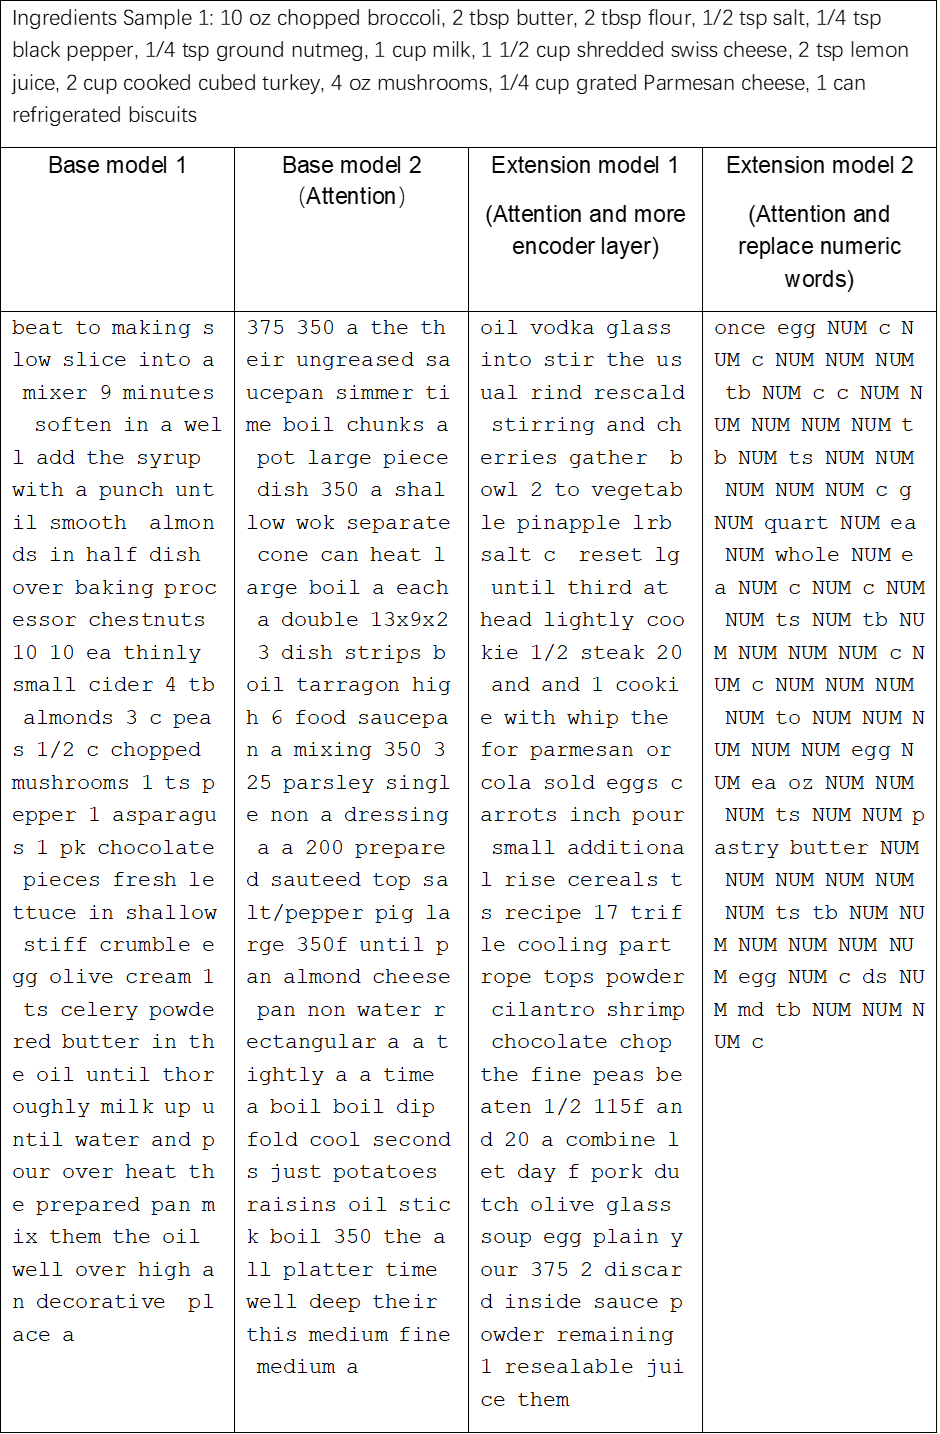

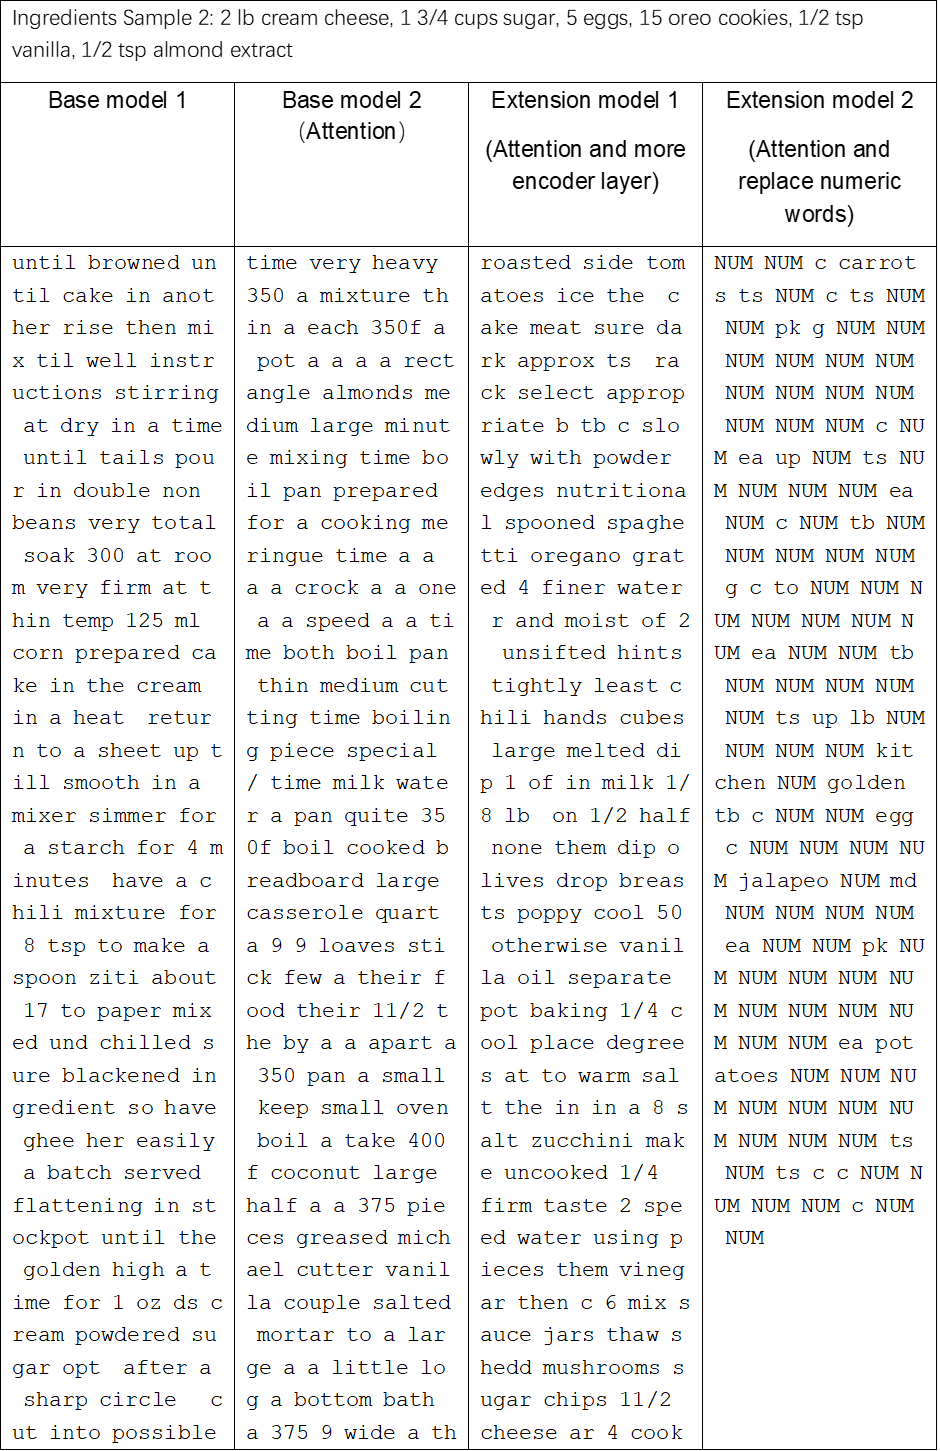